### Introduction
In this jupyter notebook, I use keras to implement several algorithms to do the fraud detection and test them with 2 common
dataset.

**Algorihtms:**  
Supervised：      
CNN   

Unsupervised：      
Isolation Forest   
LOF
Oneclass SVM

Autoencoder  (not completed yet)    

**Dataset:**  
Synthetic Financial Datasets For Fraud Detection  
https://www.kaggle.com/ntnu-testimon/paysim1/home  

Credit Card Fraud Detection  
https://www.kaggle.com/mlg-ulb/creditcardfraud/data  

**Structure**    
1. Checking environment and import pakages
2. Loading Dataset
3. Descriptive Analysis - visualize and observe the features of data.
4. Propocess data - prepare for the model
5. Building model and test with prepocessed data
6. Analysis result

## 1. Checking engironment and import pakages

In [1]:
# for computation
import numpy as np
import sklearn as sk
import pandas as pd
import keras

# for visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams, gridspec
import seaborn as sns

# for preprocess data
import joblib
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import scale

# for building models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

# for analysis
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import (cross_val_score, KFold, train_test_split,
                                     GridSearchCV, cross_validate,
                                     StratifiedKFold)

print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Sklearn version: {}".format(sk.__version__))
print("tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

Numpy version: 1.16.4
Pandas version: 0.24.2
Sklearn version: 0.23.1
tensorflow version: 2.2.0
Keras version: 2.3.0-tf


## 2. Loading dataset

**(1) creditcard dataset - "df_cre"**

In [2]:
df_cre = pd.read_csv('Data/credit/creditcard.csv')
df_cre.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**(2) synthetic dataset - "df_syn"**

In [3]:
df_syn = pd.read_csv('Data/synthetic/synthetic.csv')
df_syn.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Observation: all attribute in creditcard.csv are numeric value, but synthetic.csv have some string value

## 3. Descriptive Analysis - visualize and observe the features of data.

In [4]:
# unify target attibute name
df_com = [df_cre, df_syn]

for df in df_com:
    df.columns = df.columns.str.lower()
    if df.columns.contains('class') == True: # for credicard
        df.columns = df.columns.str.replace('class', 'target')
    if df.columns.contains('isfraud') == True: # for synthetic 
        df.columns = df.columns.str.replace('isfraud', 'target')
        df.columns = df.columns.str.replace('newbalanceorig', 'newbalanceorg')

### (1) Creditcard dataset

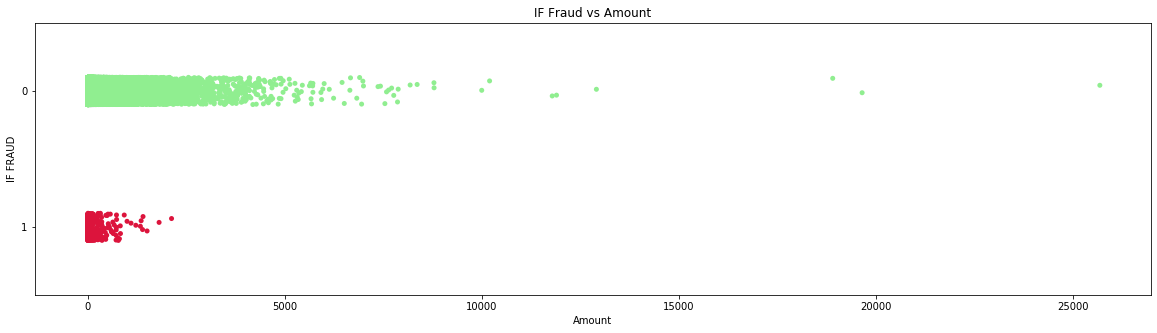

In [5]:
# Plotting frequency of Fraud VS Amounts
rcParams['figure.figsize'] = (20.0, 5.0)

sns.stripplot(x=df_cre["amount"], y=df_cre['target'].astype('category'),
             palette=['#90EE90','#DC143C']);

plt.title('IF Fraud vs Amount')
plt.xlabel('Amount')
plt.ylabel('IF FRAUD');

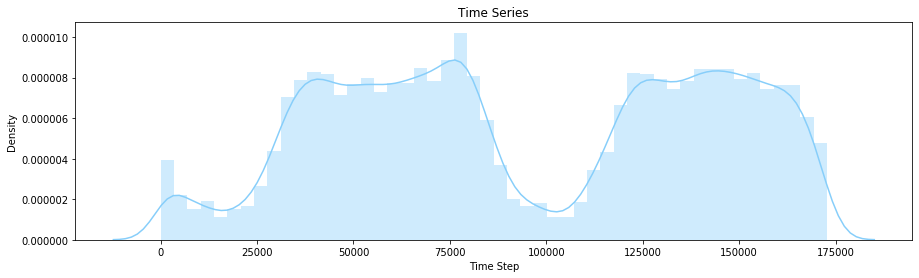

In [6]:
# Plot number of datapoints of each time interval
plt.figure(figsize=(15,4))
sns.distplot(df_cre.time, color='#87CEFA');
plt.title('Time Series')
plt.xlabel('Time Step'); plt.ylabel('Density');

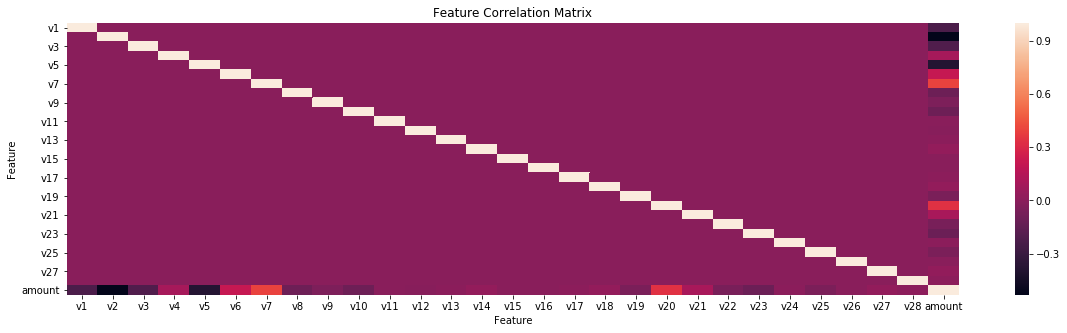

In [7]:
# view the corralationship between 'amount' and other attributes
sns.heatmap(df_cre.loc[:,'v1':'amount'].corr());
plt.title('Feature Correlation Matrix')
plt.xlabel('Feature'); 
plt.ylabel('Feature');
plt.yticks(rotation=0);

### (2) Synthetic dataset

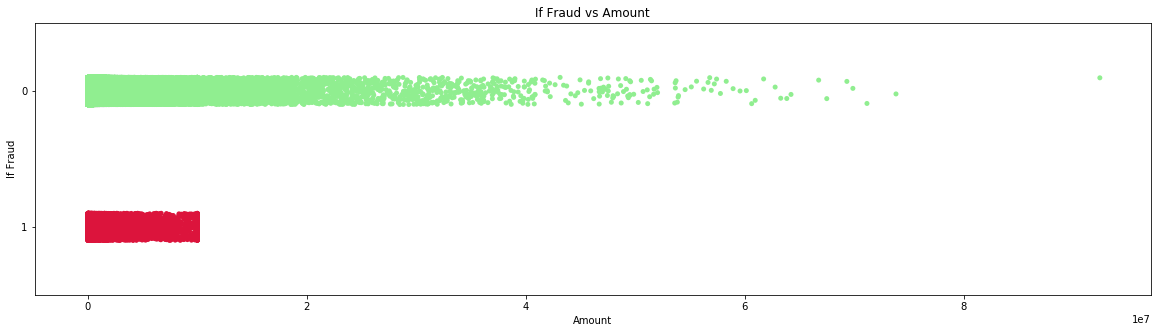

In [8]:
# Plotting frequency of Fraud VS Amounts
rcParams['figure.figsize'] = (20.0, 5.0)
sns.stripplot(x=df_syn["amount"], y=df_syn['target'].astype('category'),
             palette=['#90EE90','#DC143C']);
plt.title('If Fraud vs Amount')
plt.xlabel('Amount')
plt.ylabel('If Fraud');

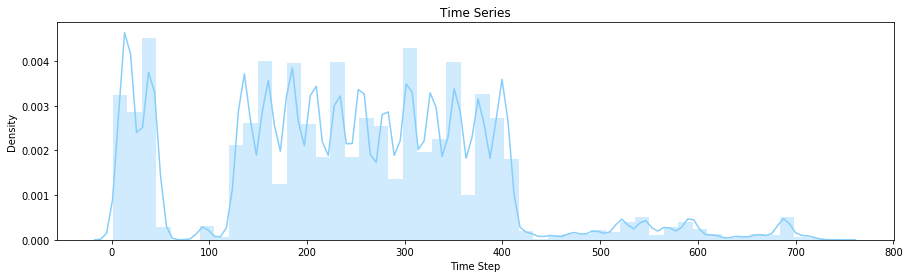

In [9]:
# Plot number of datapoints of each time interval
plt.figure(figsize=(15,4))
sns.distplot(df_syn.step, color='#87CEFA');
plt.title('Time Series')
plt.xlabel('Time Step'); plt.ylabel('Density');

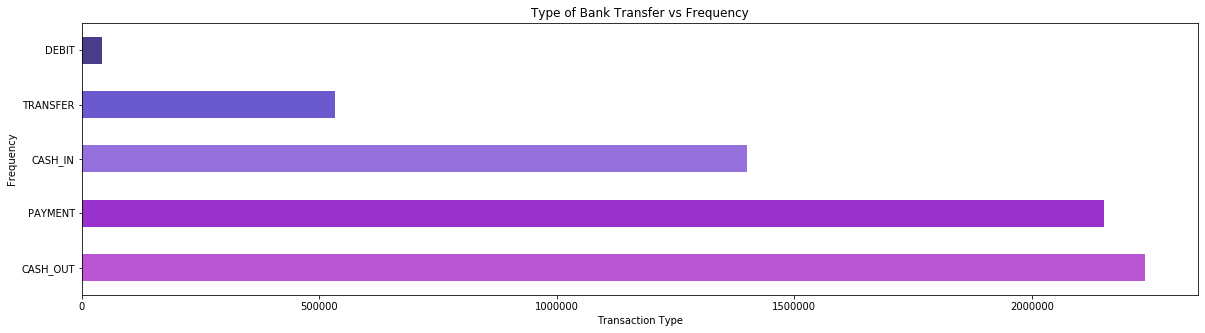

In [10]:
# View transaction type
rcParams['figure.figsize'] = (20.0, 5.0)
df_syn.type.value_counts().plot.barh(color=['#BA55D3','#9932CC','#9370DB','#6A5ACD','#483D8B']);
plt.title('Type of Bank Transfer vs Frequency');
plt.xlabel('Transaction Type')
plt.ylabel('Frequency');

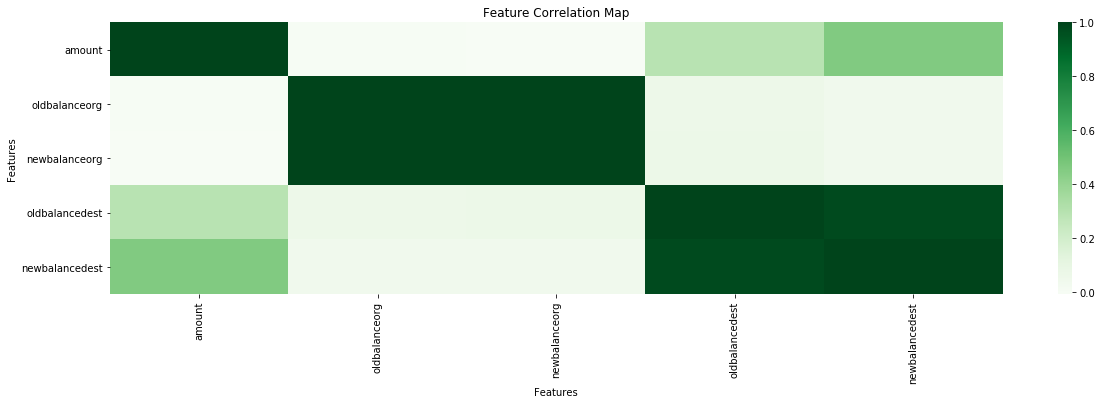

In [11]:
# view the corralationship between attribute(numercal attribute)
sns.heatmap(df_syn.select_dtypes(['int','float']).corr(), cmap=plt.cm.Greens);
plt.title('Feature Correlation Map');
plt.ylabel('Features')
plt.xlabel('Features')
plt.xticks(rotation='vertical');

## 4. Propocess data - prepare for the model

**(1) drop useless data/attribute, and code for category attributes**

In [12]:
# Creditcard dataset
### Drop attribute "time"
df_cre = df_cre.drop('time',axis=1)


# Synthetic dataset

### Encode all object colunms to categorical codes
df_syn.type = df_syn.type.astype('category').cat.codes
df_syn.nameorig = df_syn.nameorig.astype('category').cat.codes
df_syn.namedest = df_syn.namedest.astype('category').cat.codes

### Concatenate one-hot encoded type features
df_syn = pd.concat([df_syn,pd.get_dummies(df_syn.type, 'type')], axis=1).drop('type',axis=1)

### Drop attribute "isflaggedfraud"
df_syn= df_syn.drop('isflaggedfraud', axis=1)

**(2)Split and sampling data**

In [13]:
def sub_sampling(X, y, length):
    '''
    syb_sample an arra; by randomly
    '''

    assert type(X) == np.ndarray, 'Make sure X is a numpy array'
    assert type(y) == np.ndarray, "Make sure y is a numpy array"
    assert (length < len(X)), 'Numpy array is not length '

    new_index = np.random.choice(np.arange(0,len(y)), size=length, replace=False)
    X,y = X[new_index], y[new_index]


    return X, y

sub_sample_size = 100000

**spliting and sampling creditcard dataset**

In [53]:
print('Processing credit card dataset:')

# define the classes for the confusion matrix
classes_cre = list(np.unique(df_cre['target'].values))

# Encode value to numpy
X_cre = df_cre.drop('target',axis=1).values
y_cre = df_cre['target'].values

# Sub sample the dataframe
if len(X_cre) > sub_sample_size:
    X_cre, y_cre = sub_sampling(X_cre, y_cre, sub_sample_size)

# Conduct a train-test-split on the data
train_x_cre, test_x_cre, train_y_cre, test_y_cre = train_test_split(X_cre,y_cre, test_size=0.25)

# Compute the sample weights of the dataset
weights_cre = compute_sample_weight(class_weight='balanced', y=train_y_cre)

# Compuete the number of PCA comentents we are goint to use
components_cre = round(train_x_cre.shape[1]/1.5)

'''
# Saving a backup copy the original data
train_x_norm, train_y_norm = train_x.copy(), train_y.copy()
test_x_norm, test_y_norm = test_x.copy(), test_y.copy()
'''
print('\nPreprocessing(PCA and scaler:)')

pca_cre = PCA(n_components=components_cre)
train_x_cre = pca_cre.fit_transform(train_x_cre)
test_x_cre = pca_cre.transform(test_x_cre)
print('PCA Components: {}'.format(components_cre))

# Transform the data using a standard scaler
scaler = StandardScaler(copy=True)
train_x_cre = scaler.fit_transform(train_x_cre)
test_x_cre = scaler.transform(test_x_cre)
print('Standard Scaler: Yes')

# Print data shape title
print('\nData Shape:')

# Printing metrics around the shape of the datframe

print(f'Use Data: {len(X_cre)}')
print(f'Train X: {len(train_x_cre)} \t Train y: {len(train_y_cre)}')
print(f'Test  X: {len(test_x_cre)} \t Test y: {len(test_y_cre)}')
print(f'Label type: {classes_cre}')

Processing credit card dataset:

Preprocessing(PCA and scaler:)
PCA Components: 19
Standard Scaler: Yes

Data Shape:
Use Data: 100000
Train X: 75000 	 Train y: 75000
Test  X: 25000 	 Test y: 25000
Label type: [0, 1]


**spliting and sampling synthetic dataset**

In [54]:
print('Processing synthetic dataset:')

# define the classes for the confusion matrix
classes_syn = list(np.unique(df_syn['target'].values))

# Encode value to numpy
X_syn = df_syn.drop('target',axis=1).values
y_syn = df_syn['target'].values

# Sub sample the dataframe
if len(X_syn) > sub_sample_size:
    X_syn, y_syn = sub_sampling(X_syn,y_syn, sub_sample_size)

# Conduct a train-test-split on the data
train_x_syn, test_x_syn, train_y_syn, test_y_syn = train_test_split(X_syn,y_syn, test_size=0.25)

# Compute the sample weights of the dataset
weights_syn = compute_sample_weight(class_weight='balanced', y=train_y_syn)

# Compuete the number of PCA comentents we are goint to use
components_syn = round(train_x_syn.shape[1]/1.5)

'''
# Saving a backup copy the original data
train_x_norm, train_y_norm = train_x.copy(), train_y.copy()
test_x_norm, test_y_norm = test_x.copy(), test_y.copy()
'''
print('\nPreprocessing(PCA and scaler:)')
pca_syn = PCA(n_components=components_syn)
train_x_syn = pca_syn.fit_transform(train_x_syn)
test_x_syn = pca_syn.transform(test_x_syn)
print('PCA Components: {}'.format(components_syn))

# Transform the data using a standard scaler
scaler = StandardScaler(copy=True)
train_x_syn = scaler.fit_transform(train_x_syn)
test_x_syn = scaler.transform(test_x_syn)
print('Standard Scaler: Yes')

# Print data shape title
print('\nData Shape:')

# Printing metrics around the shape of the datframe

print(f'Use Data: {len(X_syn)}')
print(f'Train X: {len(train_x_syn)} \t Train y: {len(train_y_syn)}')
print(f'Test  X: {len(test_x_syn)} \t Test y: {len(test_y_syn)}')
print(f'Label type: {classes_syn}')

Processing synthetic dataset:

Preprocessing(PCA and scaler:)
PCA Components: 9
Standard Scaler: Yes

Data Shape:
Use Data: 100000
Train X: 75000 	 Train y: 75000
Test  X: 25000 	 Test y: 25000
Label type: [0, 1]


In [69]:
# create balance dataset
# count how many "fraud", select the same number of sample from those "not fraud"

# creditcard
non_fraud_cre = df_cre[df_cre['target']==0]
fraud_cre = df_cre[df_cre['target']==1]

non_fraud_cre = non_fraud_cre.sample(fraud_cre.shape[0])
df_balance_cre = fraud_cre.append(non_fraud_cre, ignore_index = True)

X_b_cre = df_balance_cre.drop('target',axis = 1)
y_b_cre = df_balance_cre['target']

b_train_x_cre,b_test_x_cre,b_train_y_cre,b_test_y_cre = train_test_split(X_b_cre,y_b_cre, test_size =0.2,random_state=0,stratify=y_b_cre)


#print(pca_cre)
#b_train_x_cre = pca_cre.fit_transform(b_train_x_cre)
#b_test_x_cre = pca_cre.transform(b_test_x_cre)

# Transform the data using a standard scaler
b_train_x_cre = scaler.fit_transform(b_train_x_cre)
b_test_x_cre = scaler.transform(b_test_x_cre)


##  synthetic
non_fraud_syn = df_syn[df_syn['target']==0]
fraud_syn = df_syn[df_syn['target']==1]

non_fraud_syn = non_fraud_syn.sample(fraud_syn.shape[0])
df_balance_syn = fraud_cre.append(non_fraud_syn, ignore_index = True)

X_b_syn = df_balance_syn.drop('target',axis = 1)
y_b_syn = df_balance_syn['target']

b_train_x_syn,b_test_x_syn,b_train_y_syn,b_test_y_syn = train_test_split(X_b_syn,y_b_syn, test_size =0.2,random_state=0,stratify=y_b_syn)

print(pca_syn)
#b_train_x_syn = pca_syn.fit_transform(b_train_x_syn)
#b_test_x_syn = pca_syn.transform(b_test_x_syn)

# Transform the data using a standard scaler
b_train_x_syn = scaler.fit_transform(b_train_x_syn)
b_test_x_syn = scaler.transform(b_test_x_syn)

print('Balanced credit card dataset:')
print(f'Use Data: {len(X_b_cre)}')
print(f'Train X: {len(b_train_x_cre)} \t Train y: {len(b_train_y_cre)}')
print(f'Test  X: {len(b_test_x_cre)} \t Test y: {len(b_test_y_cre)}')


print('\nBalanced synthetic dataset:')
print(f'Use Data: {len(X_b_syn)}')
print(f'Train X: {len(b_train_x_syn)} \t Train y: {len(b_train_y_syn)}')
print(f'Test  X: {len(b_test_x_syn)} \t Test y: {len(b_test_y_syn)}')

PCA(n_components=9)
Balanced credit card dataset:
Use Data: 984
Train X: 787 	 Train y: 787
Test  X: 197 	 Test y: 197

Balanced synthetic dataset:
Use Data: 8705
Train X: 6964 	 Train y: 6964
Test  X: 1741 	 Test y: 1741


D:\Users\60587\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## 5.Building model and test with prepocessed data

**(1) CNN**

In [102]:
cre_model = Sequential()
cre_model.add(Conv1D(32, 2, activation = 'relu',input_shape = (train_x_cre.shape[1],1)))
b_cre_model = Sequential()
b_cre_model.add(Conv1D(32, 2, activation = 'relu',input_shape = (b_train_x_cre.shape[1],1)))
syn_model = Sequential()
syn_model.add(Conv1D(32, 2, activation = 'relu',input_shape = (train_x_syn.shape[1],1)))

for model in [cre_model, b_cre_model, syn_model]:
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 2, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation ='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation ='sigmoid'))


In [103]:
cre_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 18, 32)            96        
_________________________________________________________________
batch_normalization_25 (Batc (None, 18, 32)            128       
_________________________________________________________________
dropout_36 (Dropout)         (None, 18, 32)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 17, 64)            4160      
_________________________________________________________________
batch_normalization_26 (Batc (None, 17, 64)            256       
_________________________________________________________________
dropout_37 (Dropout)         (None, 17, 64)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1088)            

In [106]:
#b_cre_model.summary()

In [104]:
#syn_model.summary()

#### (2) Anomaly detection algorithms(unsuppervised)
a. Isolation Forest   
b. Local Outlier   
c. One-class SVM  

In [111]:
state = np.random.RandomState(42)

outlier_fraction_cre = sum(df_cre['target'])/(len(df_cre)-sum(df_cre['target']))
outlier_fraction_syn = sum(df_syn['target'])/(len(df_syn)-sum(df_syn['target']))

Anomalies_cre = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(df_cre), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction_cre),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

Anomalies_syn = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(df_cre), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction_syn),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

## 6.Analysis result

**(1) CNN**

In [85]:
epochs = 20

In [107]:
## here I use creditcard to test CNN
## here I use balanced creditcard(created) to test CNN
cnn_train_x_cre = train_x_cre.reshape(train_x_cre.shape[0],train_x_cre.shape[1],1)
cnn_test_x_cre = test_x_cre.reshape(test_x_cre.shape[0],test_x_cre.shape[1],1)

cre_model.compile(optimizer=Adam(lr=0.0001),loss ='binary_crossentropy', metrics=['acc'])
cre_process = cre_model.fit(cnn_train_x_cre,train_y_cre, epochs=epochs, validation_data=(cnn_test_x_cre,test_y_cre), verbose=1)

Epoch 1/20
2344/2344 [==============================] - 10s 4ms/step - loss: 0.1704 - acc: 0.9376 - val_loss: 0.0062 - val_acc: 0.9992
Epoch 2/20
2344/2344 [==============================] - 10s 4ms/step - loss: 0.0119 - acc: 0.9978 - val_loss: 0.0057 - val_acc: 0.9994
Epoch 3/20
2344/2344 [==============================] - 10s 4ms/step - loss: 0.0071 - acc: 0.9988 - val_loss: 0.0062 - val_acc: 0.9994
Epoch 4/20
2344/2344 [==============================] - 10s 4ms/step - loss: 0.0056 - acc: 0.9991 - val_loss: 0.0060 - val_acc: 0.9994
Epoch 5/20
2344/2344 [==============================] - 10s 4ms/step - loss: 0.0056 - acc: 0.9992 - val_loss: 0.0056 - val_acc: 0.9994
Epoch 6/20
2344/2344 [==============================] - 10s 4ms/step - loss: 0.0052 - acc: 0.9992 - val_loss: 0.0053 - val_acc: 0.9994
Epoch 7/20
2344/2344 [==============================] - 11s 5ms/step - loss: 0.0047 - acc: 0.9992 - val_loss: 0.0053 - val_acc: 0.9995
Epoch 8/20
2344/2344 [==============================] -

In [113]:
## here I use balanced creditcard(created) to test CNN
b_cnn_train_x_cre = b_train_x_cre.reshape(b_train_x_cre.shape[0],b_train_x_cre.shape[1],1)
b_cnn_test_x_cre = b_test_x_cre.reshape(b_test_x_cre.shape[0],b_test_x_cre.shape[1],1)

b_cre_model.compile(optimizer=Adam(lr=0.0001),loss ='binary_crossentropy', metrics=['acc'])
b_cre_process = b_cre_model.fit(b_cnn_train_x_cre,b_train_y_cre, epochs=epochs, validation_data=(b_cnn_test_x_cre,b_test_y_cre), verbose=1)

Epoch 1/20
25/25 [==============================] - 0s 10ms/step - loss: 0.8771 - acc: 0.6531 - val_loss: 0.6185 - val_acc: 0.8680
Epoch 2/20
25/25 [==============================] - 0s 7ms/step - loss: 0.5331 - acc: 0.8018 - val_loss: 0.5834 - val_acc: 0.8680
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4614 - acc: 0.8183 - val_loss: 0.5642 - val_acc: 0.7563
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4158 - acc: 0.8526 - val_loss: 0.5482 - val_acc: 0.6142
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.3595 - acc: 0.8729 - val_loss: 0.5444 - val_acc: 0.5431
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.3305 - acc: 0.8818 - val_loss: 0.5357 - val_acc: 0.5431
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.2893 - acc: 0.8844 - val_loss: 0.5079 - val_acc: 0.5787
Epoch 8/20
25/25 [==============================] - 0s 6ms/step - loss: 0.2729 - acc: 0.9

In [114]:
# ## here I use origin sythetic to test CNN
cnn_train_x_syn = train_x_syn.reshape(train_x_syn.shape[0],train_x_syn.shape[1],1)
cnn_test_x_syn = test_x_syn.reshape(test_x_syn.shape[0],test_x_syn.shape[1],1)
syn_model.compile(optimizer=Adam(lr=0.0001),loss ='binary_crossentropy', metrics=['acc'])
syn_process = syn_model.fit(cnn_train_x_syn,train_y_syn, epochs=epochs, validation_data=(cnn_test_x_syn,test_y_syn), verbose=1)

Epoch 1/20
2344/2344 [==============================] - 8s 4ms/step - loss: 0.1129 - acc: 0.9601 - val_loss: 0.0048 - val_acc: 0.9993
Epoch 2/20
2344/2344 [==============================] - 8s 4ms/step - loss: 0.0127 - acc: 0.9978 - val_loss: 0.0043 - val_acc: 0.9995
Epoch 3/20
2344/2344 [==============================] - 9s 4ms/step - loss: 0.0096 - acc: 0.9985 - val_loss: 0.0038 - val_acc: 0.9994
Epoch 4/20
2344/2344 [==============================] - 9s 4ms/step - loss: 0.0071 - acc: 0.9988 - val_loss: 0.0035 - val_acc: 0.9994
Epoch 5/20
2344/2344 [==============================] - 8s 4ms/step - loss: 0.0068 - acc: 0.9988 - val_loss: 0.0032 - val_acc: 0.9994
Epoch 6/20
2344/2344 [==============================] - 9s 4ms/step - loss: 0.0061 - acc: 0.9990 - val_loss: 0.0029 - val_acc: 0.9994
Epoch 7/20
2344/2344 [==============================] - 12s 5ms/step - loss: 0.0062 - acc: 0.9990 - val_loss: 0.0029 - val_acc: 0.9994
Epoch 8/20
2344/2344 [==============================] - 12s 5

In [115]:
def plot_learningCurve(history, epoch):
    #plot training & val iddation accuracy values
    epoch_range = range(1,epoch+1)
    plt.plot(epoch_range, history.history['acc']) 
    plt.plot(epoch_range, history.history['val_acc'])
    plt.title("Model accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc ='upper left')
    plt.show()
    
    #plot training & val iddation loss values
    plt.plot(epoch_range, history.history['loss']) 
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title("Model loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc ='upper left')
    plt.show()

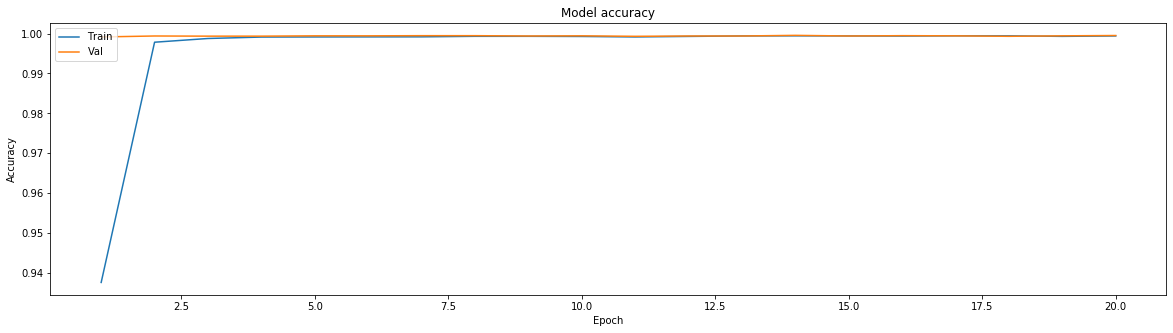

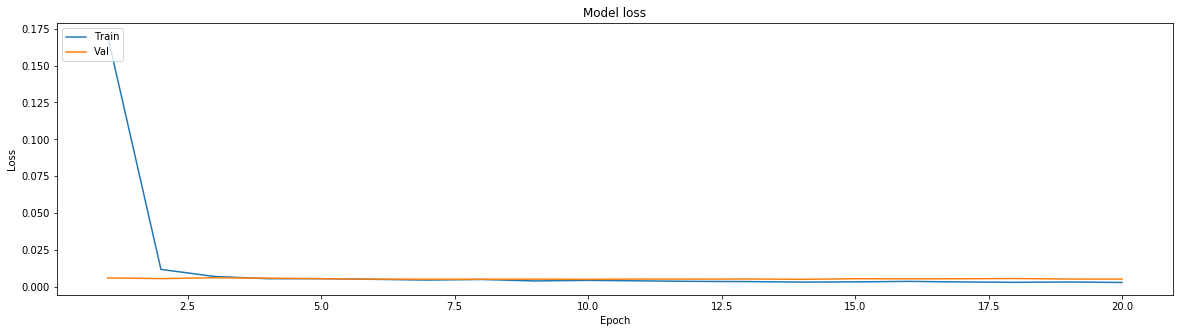

In [116]:
plot_learningCurve(cre_process,epochs)

In [118]:
#plot_learningCurve(b_cre_process,epochs)

In [119]:
#plot_learningCurve(syn_process,epochs)

In [120]:
# result of creditcard 
print("Creditcard")
predictions_cre = cre_model.predict_classes(cnn_test_x_cre)
print(classification_report(test_y_cre, predictions_cre))
print('\n')

print("Creditcard(balanced):")
b_predictions_cre = b_cre_model.predict_classes(b_cnn_test_x_cre)
print(classification_report(b_test_y_cre, b_predictions_cre))
print('\n')

# result of synthetic
# result of creditcard 
print("Synthetic:")
predictions_syn = syn_model.predict_classes(cnn_test_x_syn)
print(classification_report(test_y_syn, predictions_syn))
print('\n')
#print(confusion_matrix(b_y_test_cre, predictions_cre))     

Creditcard
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24955
           1       0.90      0.82      0.86        45

    accuracy                           1.00     25000
   macro avg       0.95      0.91      0.93     25000
weighted avg       1.00      1.00      1.00     25000



Creditcard(balanced):
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        99
           1       0.92      0.91      0.91        98

    accuracy                           0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197



Synthetic:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24965
           1       1.00      0.60      0.75        35

    accuracy                           1.00     25000
   macro avg       1.00      0.80      0.87     25000
weighted avg       1.00   

#### (2) Anomaly detection algorithms(unsupervised)
a. Isolation Forest   
b. Local Outlier   
c. One-class SVM  

**creditcard dataset**

In [122]:
X, Y = np.concatenate((train_x_cre,test_x_cre),axis=0), np.concatenate((train_y_cre, test_y_cre),axis=0)
n_outliers = sum(Y)
for i, (clf_name,clf) in enumerate(Anomalies_cre.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

D:\Users\60587\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:288: UserWarning: max_samples (284807) is greater than the total number of samples (100000). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


Isolation Forest: 226
Accuracy Score :
0.99774
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99838
           1       0.32      0.34      0.33       162

    accuracy                           1.00    100000
   macro avg       0.66      0.67      0.66    100000
weighted avg       1.00      1.00      1.00    100000

Local Outlier Factor: 336
Accuracy Score :
0.99664
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99838
           1       0.00      0.00      0.00       162

    accuracy                           1.00    100000
   macro avg       0.50      0.50      0.50    100000
weighted avg       1.00      1.00      1.00    100000

Support Vector Machine: 4880
Accuracy Score :
0.9512
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     99838
           1  

**synthenic dataset**

In [123]:
X, Y = np.concatenate((train_x_syn,test_x_syn),axis=0), np.concatenate((train_y_syn, test_y_syn),axis=0)
n_outliers = sum(Y)
for i, (clf_name,clf) in enumerate(Anomalies_syn.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

D:\Users\60587\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:288: UserWarning: max_samples (284807) is greater than the total number of samples (100000). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


Isolation Forest: 246
Accuracy Score :
0.99754
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99856
           1       0.21      0.25      0.23       144

    accuracy                           1.00    100000
   macro avg       0.60      0.62      0.61    100000
weighted avg       1.00      1.00      1.00    100000

Local Outlier Factor: 270
Accuracy Score :
0.9973
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99856
           1       0.02      0.01      0.01       144

    accuracy                           1.00    100000
   macro avg       0.51      0.51      0.51    100000
weighted avg       1.00      1.00      1.00    100000

Support Vector Machine: 4961
Accuracy Score :
0.95039
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     99856
           1  

#### Reference


